# Co to filtr?

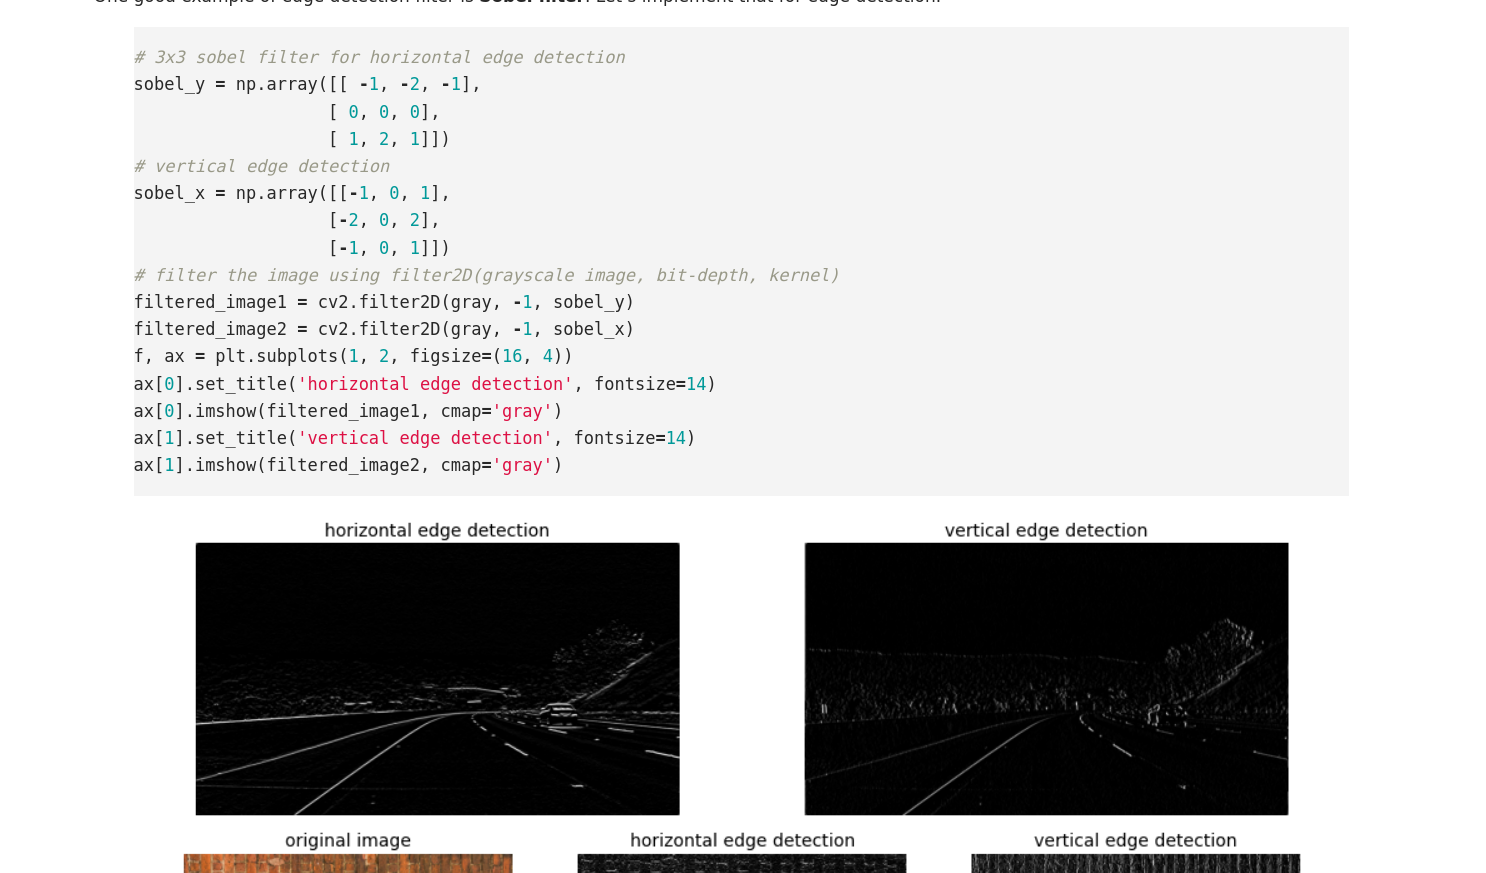

In [ ]:
# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reshape and scale the images
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

# Build the model

In [ ]:
# filtry chcemy miec recznie w numpy

# Filtry jako feature'y

In [ ]:
(28,28)

transformed_image = np.zeros((28,28,10))
transformed_image[:,:,0] = image
for idx, filtr in enumerate(filters): #9 filtrow
    transformed_image[:,:,idx+1] = cv2.filter2D(image, -1, filtr)

    


In [ ]:
regresja logistyczna na oryginalnych obrazkach ale train_data[::10]


In [ ]:
regresja logistyczna na przetransformowanych obrazkach ale train_data[::10]
#tutaj chcemy zobaczyc poprawe w accuracy

# Sieć neuronowa konwolucyjna dla mnista

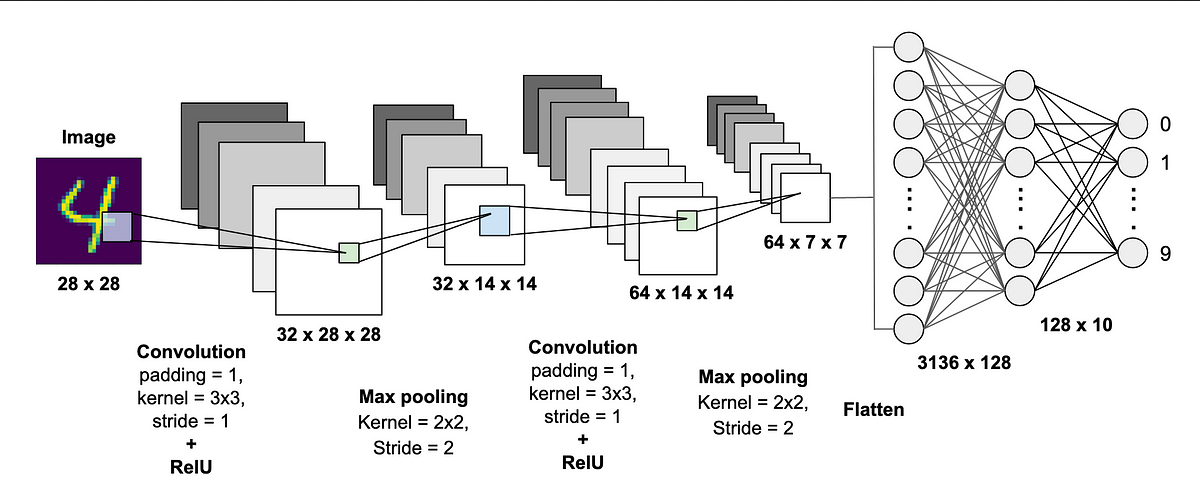

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reshape and scale the images
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


# pseudo konwolucyjna siec neuronowa

teraz na mniscie to samo co na konkursie z patchami z kmeansow